In [1]:
import os
from pathlib import Path
import logging
import itertools

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass

sns.set_style("darkgrid")
matplotlib.rcParams['font.family'] = "serif"
PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

Load data

In [2]:
config = CapstoneConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)

In [3]:
xls = pd.ExcelFile(os.path.join(data.data_path, "Regulatory Requirements.xlsx"))
df = pd.read_excel(xls, "Requirements List")
df.head(2)

,id,Regulation,Title / Chapter / Sub part,Chapter / Section,Article / Paragraph,Text,Date,Product Type,GxP,Regulatory Requirement Type,Full article reference,Mapped to a standard?,Standard mapping?
0,1,Brazil ANVISA GMP MD,Chapter 2 General Quality System Requirements,2.1. General Provisions,2.1.1,General Quality System Requirements […] Genera...,2013-03-28 00:00:00,Medical Device,GMP,Core,Brazil ANVISA GMP MD 2.1.1,Mapped to a standard,Regulatory Standards Management
1,2,Brazil ANVISA GMP MD,Chapter 2 General Quality System Requirements,2.2. Management responsibility,2.2.1,General Quality System Requirements […] Manage...,2013-03-28 00:00:00,Medical Device,GMP,Core,Brazil ANVISA GMP MD 2.2.1,Mapped to a standard,"Quality Planning, \nQuality Management"


Assign constants for useful columns

In [4]:
TEXT = "Text"
TARGET = "Standard mapping?"
REQUIREMENT = "Regulatory Requirement Type"
IS_MAPPED = "Mapped to a standard?"
IS_MAPPED_TRUE = "Mapped to a standard"

In [5]:
df.value_counts(IS_MAPPED)

Mapped to a standard?
No mapping              6326
Mapped to a standard    3906
dtype: int64

In [6]:
# data shape
print(f"Number of rows: {df.shape[0]}")
print(
    f"\n{sum(df[TARGET].isna())/df.shape[0]*100:.2f}",
    "percent of data doesn't get mapped to a label. We will drop these rows."
)
print(
    f"\nNumber of columns: {df.shape[1]}",
    f"\nBut only two columns, `{TEXT}`, `{REQUIREMENT}` and `{TARGET}` are of interest.",
    "\nWe will drop the remaining columns."
)


Number of rows: 10232

61.83 percent of data doesn't get mapped to a label. We will drop these rows.

Number of columns: 13 
But only two columns, `Text`, `Regulatory Requirement Type` and `Standard mapping?` are of interest. 
We will drop the remaining columns.


In [7]:
df[REQUIREMENT].value_counts()

Core        6316
Non-Core    2855
Obsolete     849
Non-core     168
non-core      44
Name: Regulatory Requirement Type, dtype: int64

Replace redundant categories in `Regulatory Requirement Type`

In [8]:
requirement_map = {
    "Non-Core": "Non-core",
    "Non-core": "Non-core",
    "non-core": "Non-core",
    "Core": "Core",
    "Obsolete": "Obsolete"
}
df[REQUIREMENT] = df[REQUIREMENT].map(requirement_map)
df[REQUIREMENT].value_counts()

Core        6316
Non-core    3067
Obsolete     849
Name: Regulatory Requirement Type, dtype: int64

In [9]:
# Drop rows with no assigned labels
df = df[df[IS_MAPPED].isin([IS_MAPPED_TRUE])].copy()
df.reset_index(drop=True, inplace=True)
# Keep only relevant columns
df = df[[TEXT, TARGET, REQUIREMENT]].copy()
df.isna().sum()

Text                           0
Standard mapping?              0
Regulatory Requirement Type    0
dtype: int64

In [10]:
# Convert target column into list of labels
df[TARGET] = \
    df[TARGET].str.lower() \
    .apply(lambda x: list(x.split("\n"))) \
    .apply(lambda x: [y.split(",") for y in x]) \
    .apply(lambda x: list(itertools.chain(*x))) \
    .apply(lambda x: [y.strip().replace("-", " ") for y in x if y.strip() != ""]).copy()

In [11]:
# Binarize target column
mlb =  MultiLabelBinarizer()
mlb.fit(df[TARGET])
df = df.join(pd.DataFrame(
    mlb.transform(df[TARGET]),
    columns=mlb.classes_,
    index=df.index
)).copy()
df.head(2)

,Text,Standard mapping?,Regulatory Requirement Type,acquisition and divestiture,audit inspection,calibration,capa,change control,change controls,clinical research,...,regulatory standards management,risk management,samd,stability programs,storage and distribution,training,udi and serialization,utilities and equipment,vigilance,vmp
0,General Quality System Requirements […] Genera...,[regulatory standards management],Core,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,General Quality System Requirements […] Manage...,"[quality planning, quality management]",Core,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Define useful constants

In [12]:
COLOR = "darkcyan"

### Analyzing target distribution

How many regulations have multiple labels?

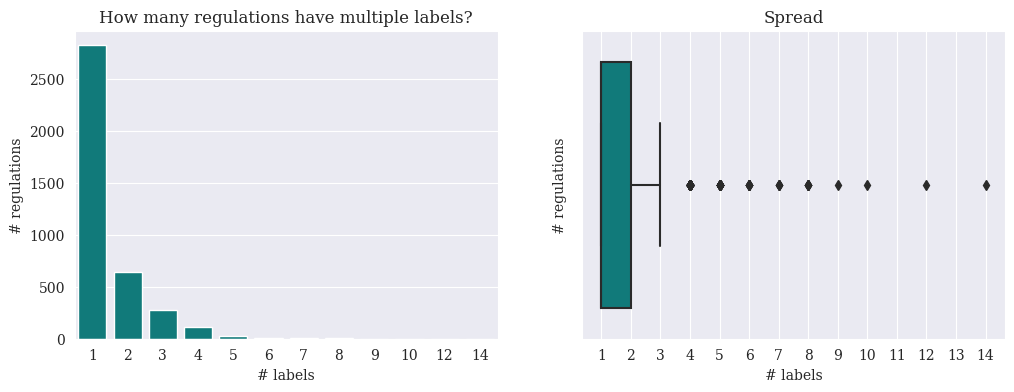

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x=df[TARGET].apply(lambda x: len(x)).values, color=COLOR, ax=ax[0])
ax[0].set_xlabel("# labels")
ax[0].set_ylabel("# regulations")
ax[0].set_title("How many regulations have multiple labels?")

sns.boxplot(x=df[TARGET].apply(lambda x: len(x)).values, color=COLOR, ax=ax[1])
ax[1].set_xlabel("# labels")
ax[1].set_ylabel("# regulations")
ax[1].set_title("Spread")
ax[1].set_xticks([i for i in range(1, 15)])
plt.show();

Number of regulations (samples) per label

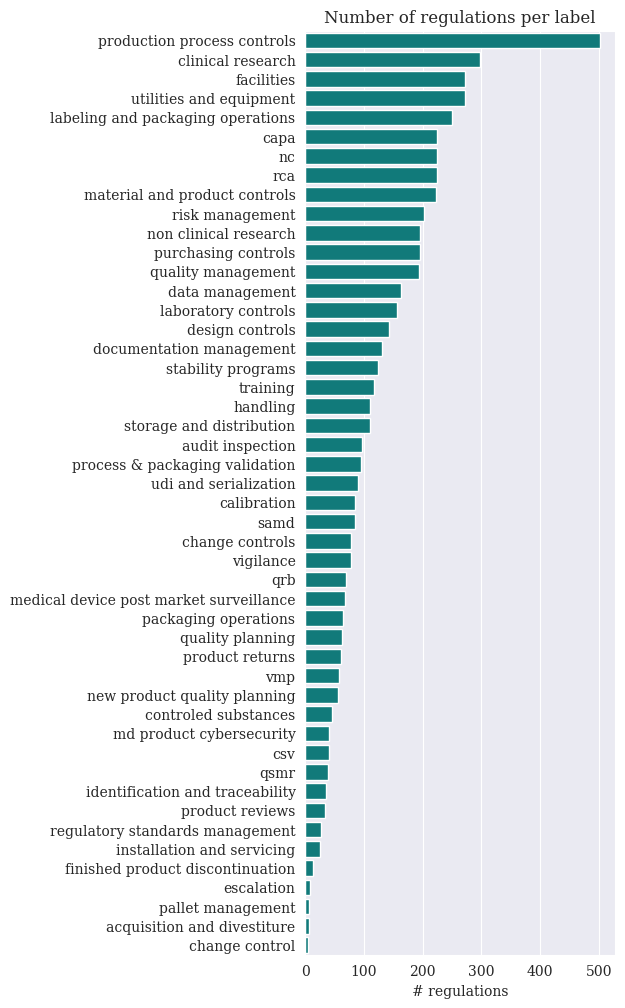

In [14]:
regulation_per_label = sorted(
    list(zip(mlb.classes_, df[mlb.classes_].sum(axis=0))),
    key=lambda x: x[1],
    reverse=True
)
regulations, labels = map(list, zip(*regulation_per_label))

plt.figure(figsize=(4, 12))
sns.barplot(x=labels, y=regulations, color=COLOR)
plt.xlabel("# regulations")
plt.title("Number of regulations per label")
plt.show();

Number of samples by category for each Regulatory Requirement Type: `Core`, `Non-core`, `Obsolete`

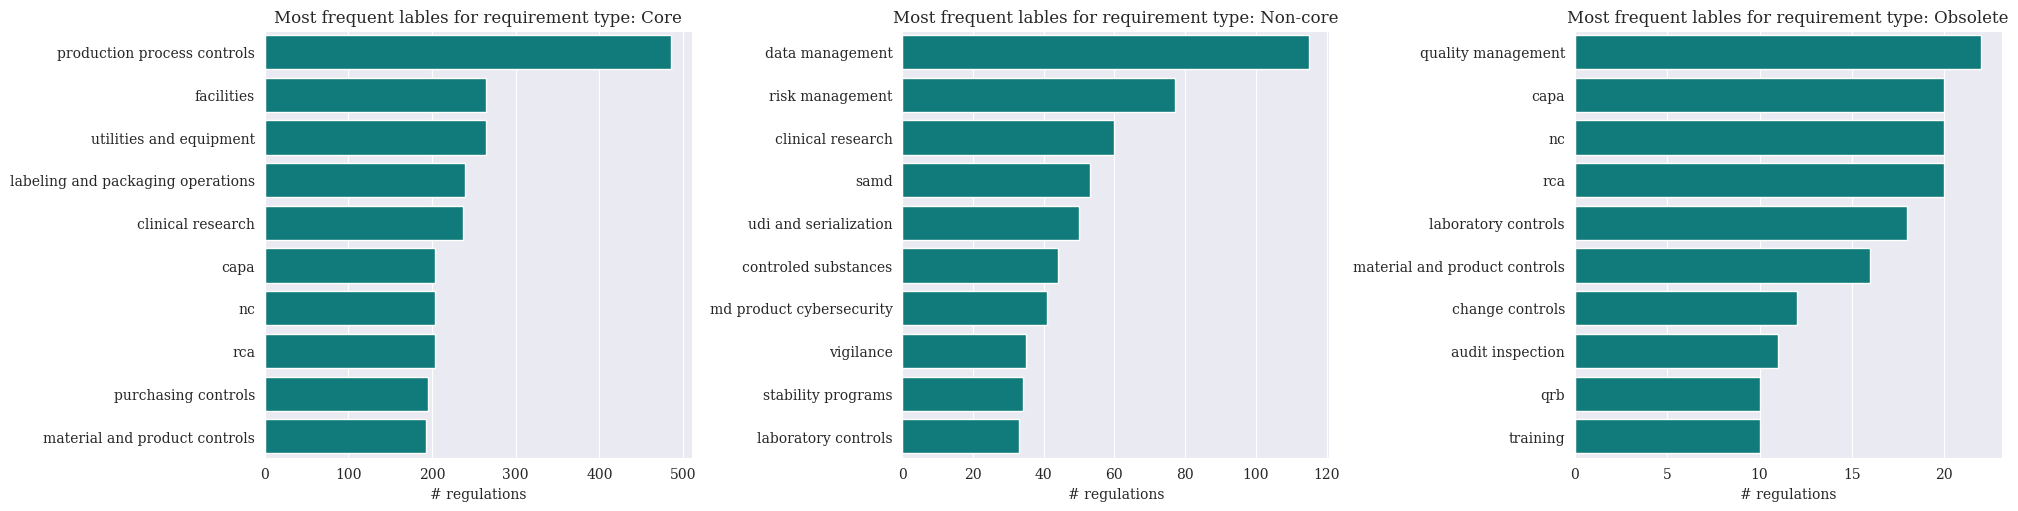

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), constrained_layout=True)
regulation_per_label = sorted(
    list(zip(mlb.classes_, df[df[REQUIREMENT].isin(["Core"])][mlb.classes_].sum(axis=0))),
    key=lambda x: x[1],
    reverse=True
)[0:10]
regulations, labels = map(list, zip(*regulation_per_label))
sns.barplot(x=labels, y=regulations, color=COLOR, ax=ax[0])
regulation_per_label = sorted(
    list(zip(mlb.classes_, df[df[REQUIREMENT].isin(["Non-core"])][mlb.classes_].sum(axis=0))),
    key=lambda x: x[1],
    reverse=True
)[0:10]
regulations, labels = map(list, zip(*regulation_per_label))
sns.barplot(x=labels, y=regulations, color=COLOR, ax=ax[1])
regulation_per_label = sorted(
    list(zip(mlb.classes_, df[df[REQUIREMENT].isin(["Obsolete"])][mlb.classes_].sum(axis=0))),
    key=lambda x: x[1],
    reverse=True
)[0:10]
regulations, labels = map(list, zip(*regulation_per_label))
sns.barplot(x=labels, y=regulations, color=COLOR, ax=ax[2])
ax[0].set_xlabel("# regulations")
ax[1].set_xlabel("# regulations")
ax[2].set_xlabel("# regulations")
ax[0].set_title("Most frequent lables for requirement type: Core")
ax[1].set_title("Most frequent lables for requirement type: Non-core")
ax[2].set_title("Most frequent lables for requirement type: Obsolete")
plt.show();

Define useful columns

In [16]:
CLEANED = "cleaned_text"
DOC = "Doc"

### Regulations - Length analysis

In [17]:
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(["shall"])
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
## Clean text (regluations)
# Conver to lower case
df[TEXT] = df[TEXT].str.lower()
# Remove HTML
df[TEXT] = df[TEXT].str.replace("<[^<]+?>", " ", regex=True)
# Remove symbols
df[TEXT] = df[TEXT].str.replace(r"[/(){}\[\]\|@,;\-]", " ", regex=True)
# Remove punctuation
df[TEXT] = df[TEXT].str.replace(r"[^\w\s]", " ", regex=True)
# Tokenize
df[TEXT] = df[TEXT].apply(lambda x: word_tokenize(x))
# Remove stopwords
df[TEXT] = df[TEXT].apply(lambda x: [word for word in x if word not in stop_words])
# Lemmatize
df[TEXT] = df[TEXT].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
# Join
df[TEXT] = df[TEXT].apply(lambda x: " ".join(x))

In [18]:
df.head(2)

,Text,Standard mapping?,Regulatory Requirement Type,acquisition and divestiture,audit inspection,calibration,capa,change control,change controls,clinical research,...,regulatory standards management,risk management,samd,stability programs,storage and distribution,training,udi and serialization,utilities and equipment,vigilance,vmp
0,general quality system requirement general pro...,[regulatory standards management],Core,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,general quality system requirement management ...,"[quality planning, quality management]",Core,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


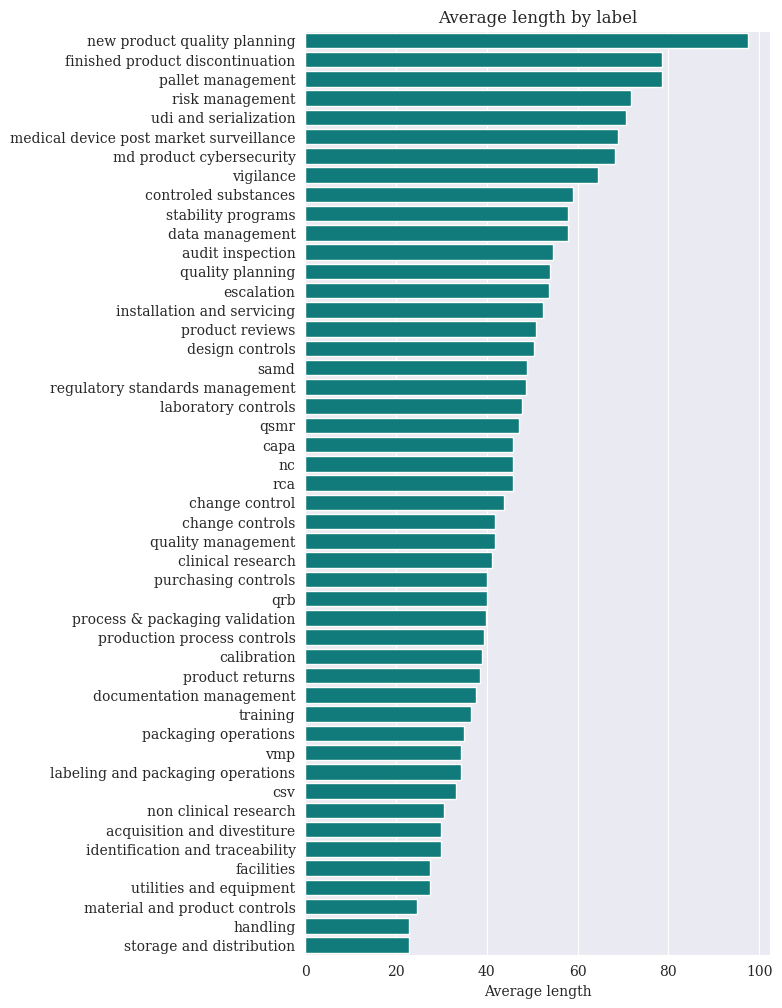

In [19]:
average_length_by_label = []
for label in mlb.classes_:
    length = \
        df[df[label].isin([1])][TEXT] \
        .apply(lambda x: word_tokenize(x)) \
        .apply(lambda x: len(x)).mean()
    average_length_by_label.append(length)
average_length_by_label = sorted(
    zip(mlb.classes_, average_length_by_label),
    key=lambda x: x[1],
    reverse=True
)
label, average_length = map(list, zip(*average_length_by_label))
plt.figure(figsize=(6, 12))
sns.barplot(x=average_length, y=label, color=COLOR)
plt.xlabel("Average length")
plt.title("Average length by label")
plt.show();

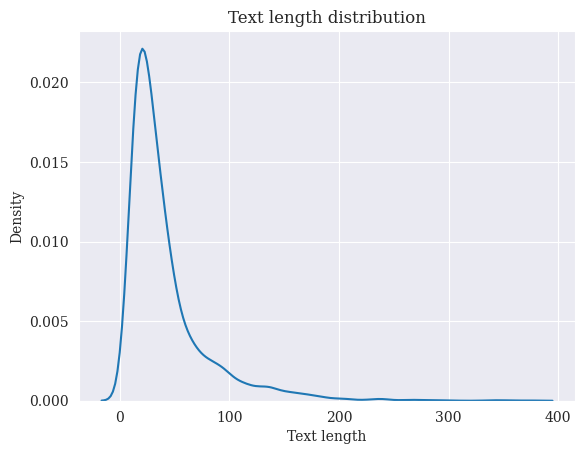

In [20]:
length = df[TEXT].apply(lambda x: word_tokenize(x)).apply(lambda x: len(x)).values
sns.kdeplot(length)
plt.xlabel("Text length")
plt.title("Text length distribution")
plt.show();

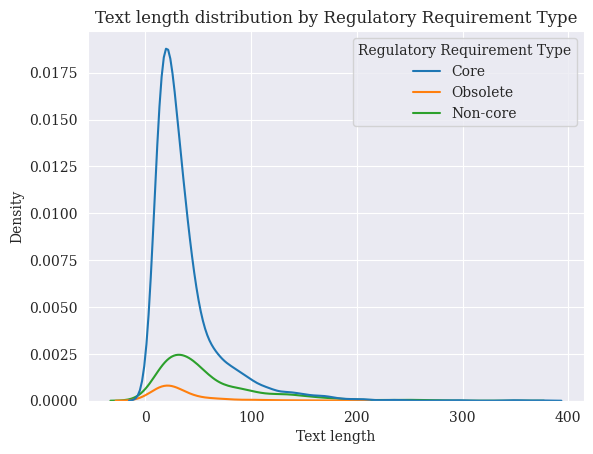

In [21]:
TEXT_LENGTH = "Text Length"
df[TEXT_LENGTH] = df[TEXT].apply(lambda x: word_tokenize(x)).apply(lambda x: len(x)).values
sns.kdeplot(data=df, x=TEXT_LENGTH, hue=REQUIREMENT)
plt.xlabel("Text length")
plt.title(f"Text length distribution by {REQUIREMENT}")
plt.show();

### N-gram Analysis

In [22]:
# Utility function to generate n-grams
def topK_ngrams(corpus: pd.Series, n: int, K: int):
    vectorizer = CountVectorizer(ngram_range=(n, n), analyzer="word")
    sparse_matrix = vectorizer.fit_transform(corpus)
    frequencies = sum(sparse_matrix).toarray()[0]
    frequencies = sorted(
        zip(frequencies, vectorizer.get_feature_names_out()),
        key=lambda x: x[0],
        reverse=True
    )
    frequencies = frequencies[:K]
    counts, ngrams = map(list, zip(*frequencies))
    return ngrams, counts

N-grams for whole corpus

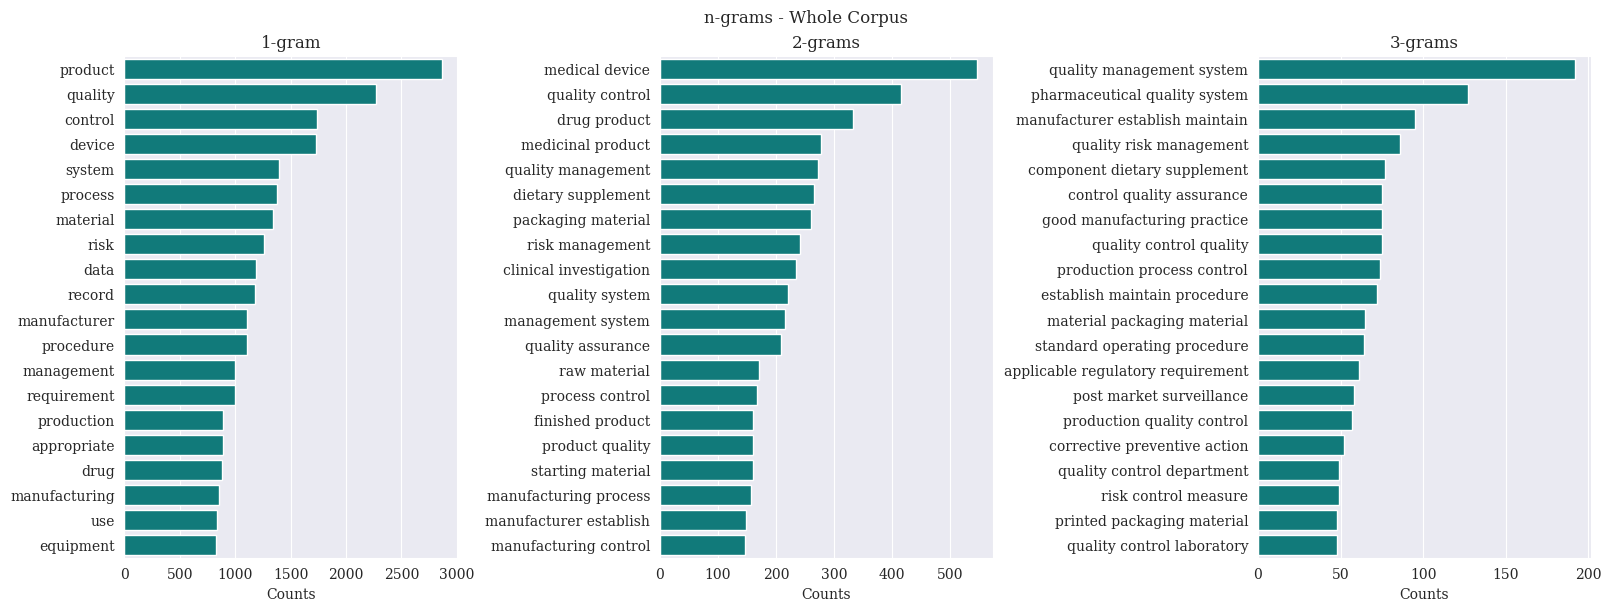

In [23]:
corpus = df[TEXT]
fig, ax = plt.subplots(1, 3, figsize=(16, 6), constrained_layout=True)
ngrams, counts = topK_ngrams(corpus, 1, 20)
sns.barplot(x=counts, y=ngrams, color=COLOR, ax=ax[0])
ngrams, counts = topK_ngrams(corpus, 2, 20)
sns.barplot(x=counts, y=ngrams, color=COLOR, ax=ax[1])
ngrams, counts = topK_ngrams(corpus, 3, 20)
sns.barplot(x=counts, y=ngrams, color=COLOR, ax=ax[2])
ax[0].set_xlabel("Counts")
ax[1].set_xlabel("Counts")
ax[2].set_xlabel("Counts")
ax[0].set_title("1-gram")
ax[1].set_title("2-grams")
ax[2].set_title("3-grams")
fig.suptitle("n-grams - Whole Corpus")
plt.show();

N-grams for 3 most frequent labels

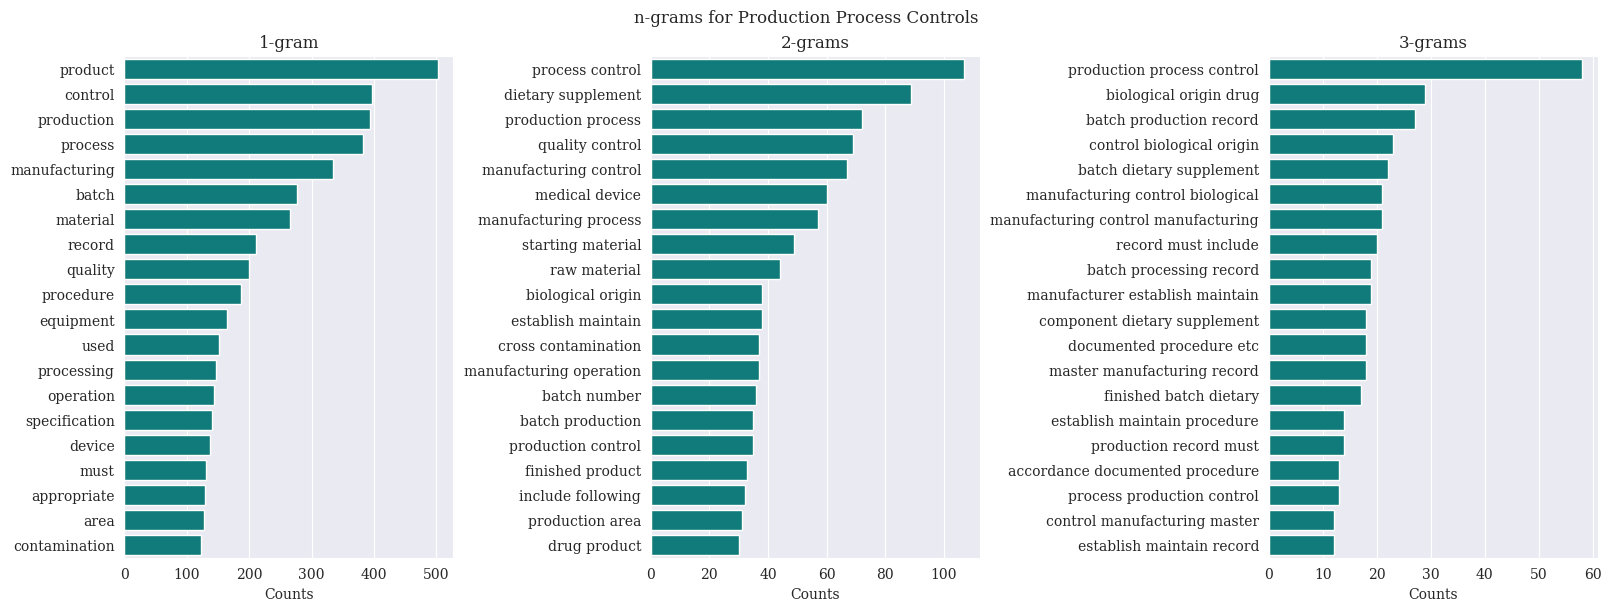

In [24]:
corpus = df[df["production process controls"].isin([1])][TEXT]
fig, ax = plt.subplots(1, 3, figsize=(16, 6), constrained_layout=True)
ngrams, counts = topK_ngrams(corpus, 1, 20)
sns.barplot(x=counts, y=ngrams, color=COLOR, ax=ax[0])
ngrams, counts = topK_ngrams(corpus, 2, 20)
sns.barplot(x=counts, y=ngrams, color=COLOR, ax=ax[1])
ngrams, counts = topK_ngrams(corpus, 3, 20)
sns.barplot(x=counts, y=ngrams, color=COLOR, ax=ax[2])
ax[0].set_xlabel("Counts")
ax[1].set_xlabel("Counts")
ax[2].set_xlabel("Counts")
ax[0].set_title("1-gram")
ax[1].set_title("2-grams")
ax[2].set_title("3-grams")
fig.suptitle("n-grams for Production Process Controls")
plt.show();

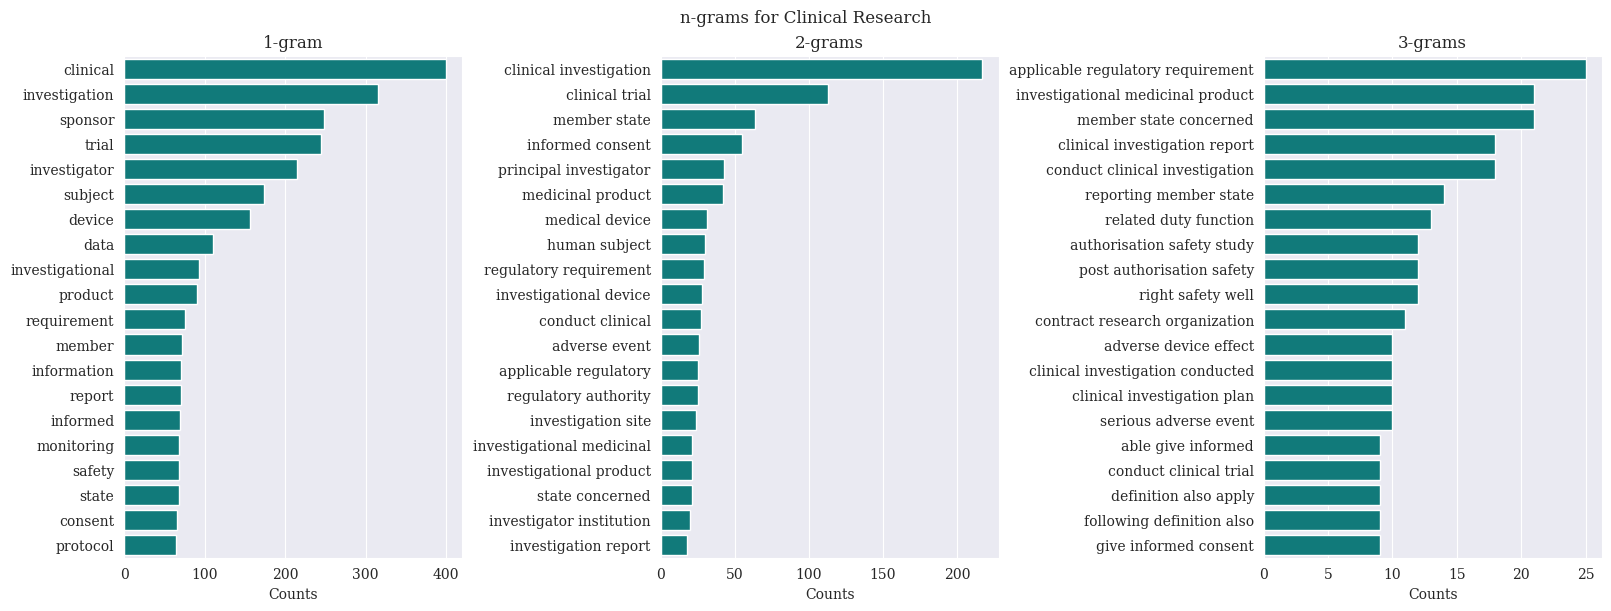

In [25]:
corpus = df[df["clinical research"].isin([1])][TEXT]
fig, ax = plt.subplots(1, 3, figsize=(16, 6), constrained_layout=True)
ngrams, counts = topK_ngrams(corpus, 1, 20)
sns.barplot(x=counts, y=ngrams, color=COLOR, ax=ax[0])
ngrams, counts = topK_ngrams(corpus, 2, 20)
sns.barplot(x=counts, y=ngrams, color=COLOR, ax=ax[1])
ngrams, counts = topK_ngrams(corpus, 3, 20)
sns.barplot(x=counts, y=ngrams, color=COLOR, ax=ax[2])
ax[0].set_xlabel("Counts")
ax[1].set_xlabel("Counts")
ax[2].set_xlabel("Counts")
ax[0].set_title("1-gram")
ax[1].set_title("2-grams")
ax[2].set_title("3-grams")
fig.suptitle("n-grams for Clinical Research")
plt.show();

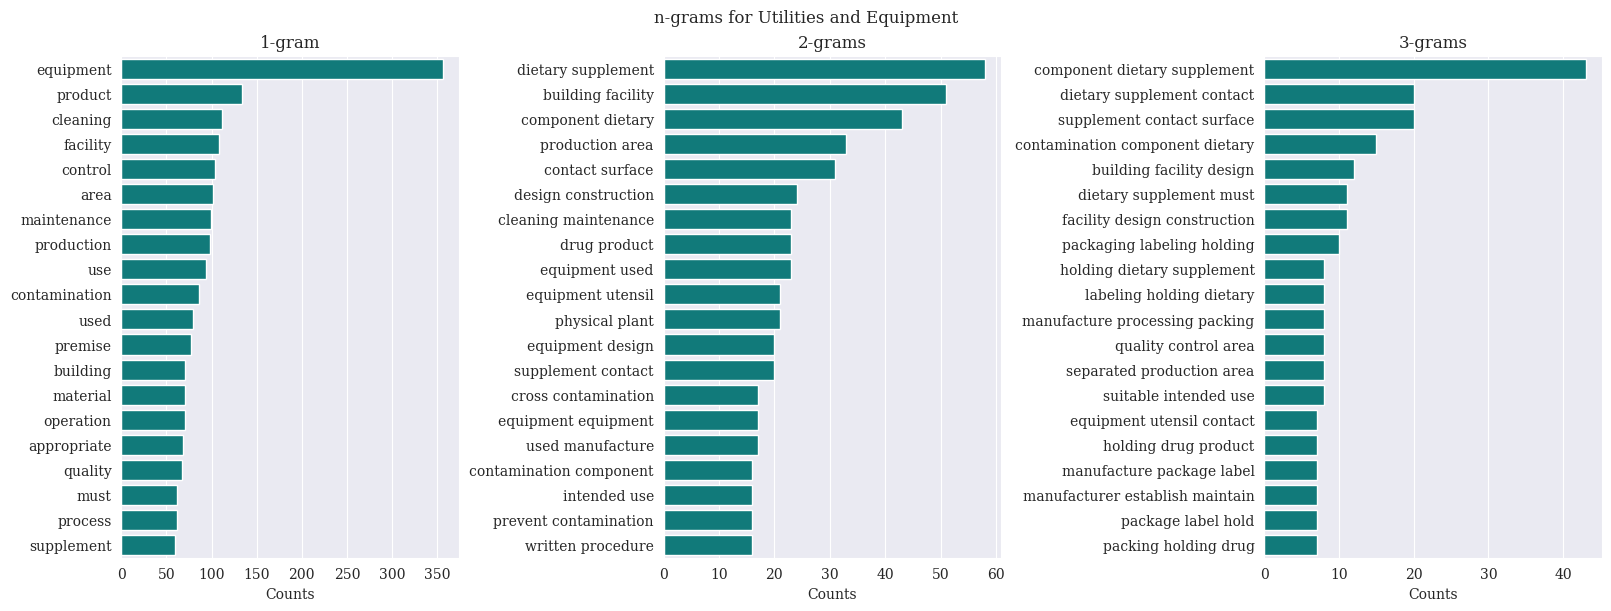

In [26]:
corpus = df[df["utilities and equipment"].isin([1])][TEXT]
fig, ax = plt.subplots(1, 3, figsize=(16, 6), constrained_layout=True)
ngrams, counts = topK_ngrams(corpus, 1, 20)
sns.barplot(x=counts, y=ngrams, color=COLOR, ax=ax[0])
ngrams, counts = topK_ngrams(corpus, 2, 20)
sns.barplot(x=counts, y=ngrams, color=COLOR, ax=ax[1])
ngrams, counts = topK_ngrams(corpus, 3, 20)
sns.barplot(x=counts, y=ngrams, color=COLOR, ax=ax[2])
ax[0].set_xlabel("Counts")
ax[1].set_xlabel("Counts")
ax[2].set_xlabel("Counts")
ax[0].set_title("1-gram")
ax[1].set_title("2-grams")
ax[2].set_title("3-grams")
fig.suptitle("n-grams for Utilities and Equipment")
plt.show();

### Hygiene (Toy) Dataset

In [27]:
df = pd.read_csv(os.path.join(data.data_path, "jnj_hygiene_ft_training_data.csv"))
df.head(3)

,prompt,completion,char_length
0,Text: (2) The sanitation program referred to i...,hygiene,254
1,Text: (3) Washing hands thoroughly (and saniti...,hygiene,269
2,"Text: (8) Not eating food, chewing gum, drinki...",hygiene,223


In [28]:
df.shape

(818, 3)

In [29]:
df.isna().sum()

prompt         0
completion     0
char_length    0
dtype: int64

Define useful constants

In [30]:
TEXT = "prompt"
TARGET = "completion"

In [31]:
df[TARGET].unique()

array([' hygiene', ' other'], dtype=object)

In [32]:
target_map = {
    " hygiene": "hygiene",
    " other": "other"
}
df[TARGET] = df[TARGET].map(target_map)
df[TARGET].unique()

array(['hygiene', 'other'], dtype=object)

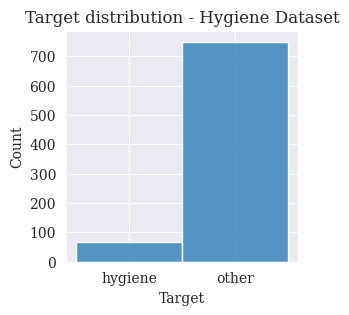

In [33]:
plt.figure(figsize = (3, 3))
plt.title("No.hygiene vs No.other")
sns.histplot(data=df, x=TARGET)
plt.ylabel("Count")
plt.xlabel("Target")
plt.title("Target distribution - Hygiene Dataset")
plt.show();

In [34]:
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(["shall"])
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
## Clean text (regluations)
df[TEXT] = df[TEXT].apply(lambda x: x[10:-10])
# Conver to lower case
df[TEXT] = df[TEXT].str.lower()
# Remove HTML
df[TEXT] = df[TEXT].str.replace("<[^<]+?>", " ", regex=True)
# Remove symbols
df[TEXT] = df[TEXT].str.replace(r"[/(){}\[\]\|@,;\-]", " ", regex=True)
# Remove punctuation
df[TEXT] = df[TEXT].str.replace(r"[^\w\s]", " ", regex=True)
# Tokenize
df[TEXT] = df[TEXT].apply(lambda x: word_tokenize(x))
# Remove stopwords
df[TEXT] = df[TEXT].apply(lambda x: [word for word in x if word not in stop_words])
# Lemmatize
df[TEXT] = df[TEXT].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
# Join
df[TEXT] = df[TEXT].apply(lambda x: " ".join(x))

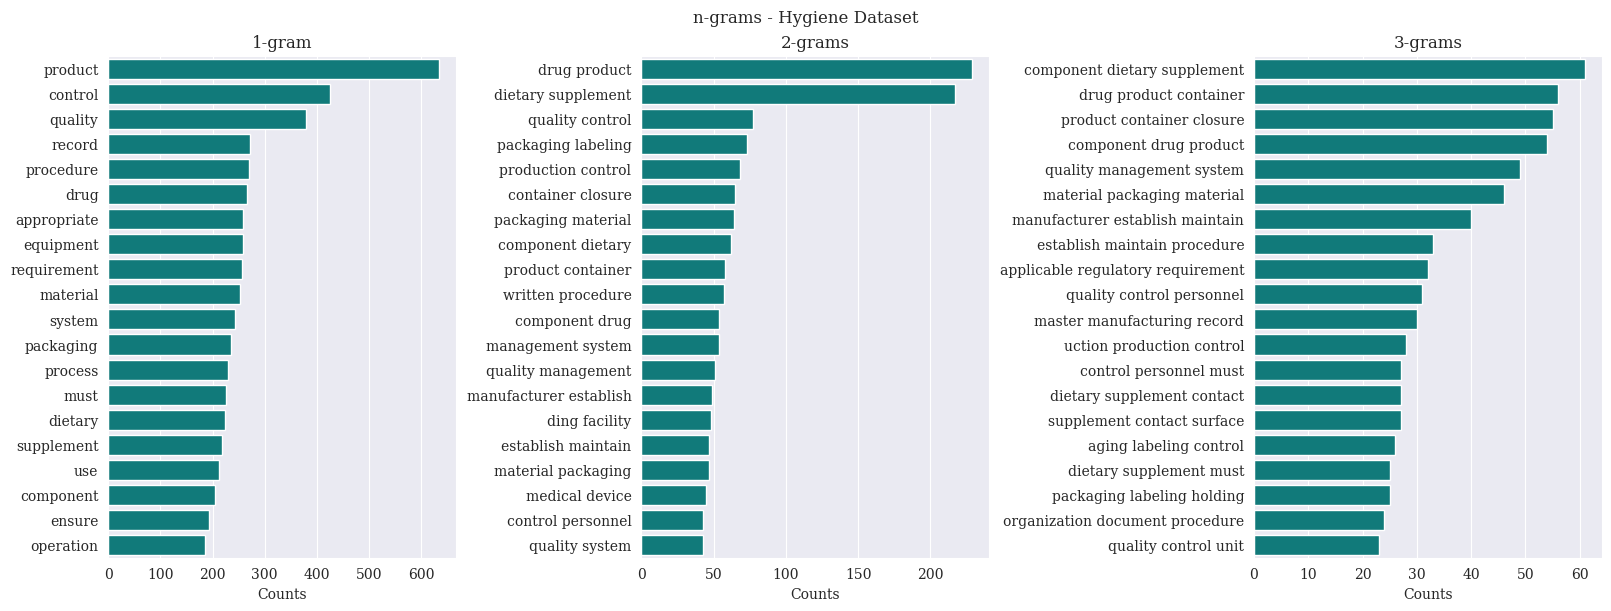

In [35]:
corpus = df[TEXT]
fig, ax = plt.subplots(1, 3, figsize=(16, 6), constrained_layout=True)
ngrams, counts = topK_ngrams(corpus, 1, 20)
sns.barplot(x=counts, y=ngrams, color=COLOR, ax=ax[0])
ngrams, counts = topK_ngrams(corpus, 2, 20)
sns.barplot(x=counts, y=ngrams, color=COLOR, ax=ax[1])
ngrams, counts = topK_ngrams(corpus, 3, 20)
sns.barplot(x=counts, y=ngrams, color=COLOR, ax=ax[2])
ax[0].set_xlabel("Counts")
ax[1].set_xlabel("Counts")
ax[2].set_xlabel("Counts")
ax[0].set_title("1-gram")
ax[1].set_title("2-grams")
ax[2].set_title("3-grams")
fig.suptitle("n-grams - Hygiene Dataset")
plt.show();

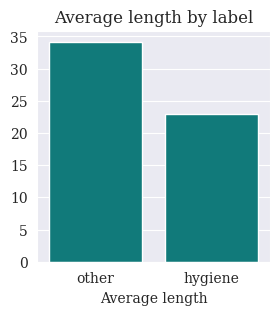

In [36]:
labels = ["hygiene", "other"]
average_length_by_label = []
for label in labels:
    length = \
        df[df[TARGET].isin([label])][TEXT] \
        .apply(lambda x: word_tokenize(x)) \
        .apply(lambda x: len(x)).mean()
    average_length_by_label.append(length)
average_length_by_label = sorted(
    zip(labels, average_length_by_label),
    key=lambda x: x[1],
    reverse=True
)
label, average_length = map(list, zip(*average_length_by_label))
plt.figure(figsize=(3, 3))
sns.barplot(y=average_length, x=label, color=COLOR)
plt.xlabel("Average length")
plt.title("Average length by label")
plt.show();

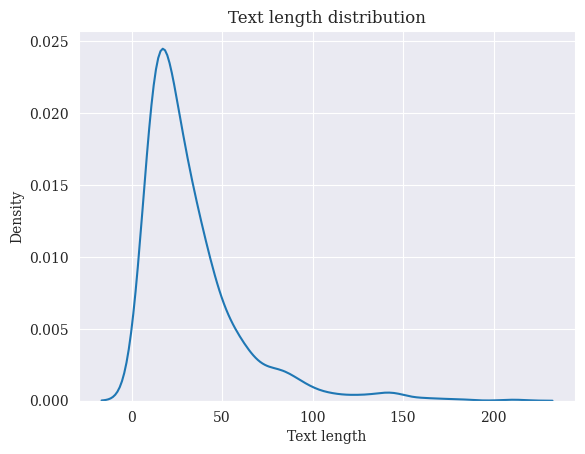

In [37]:
length = df[TEXT].apply(lambda x: word_tokenize(x)).apply(lambda x: len(x)).values
sns.kdeplot(length)
plt.xlabel("Text length")
plt.title("Text length distribution")
plt.show();

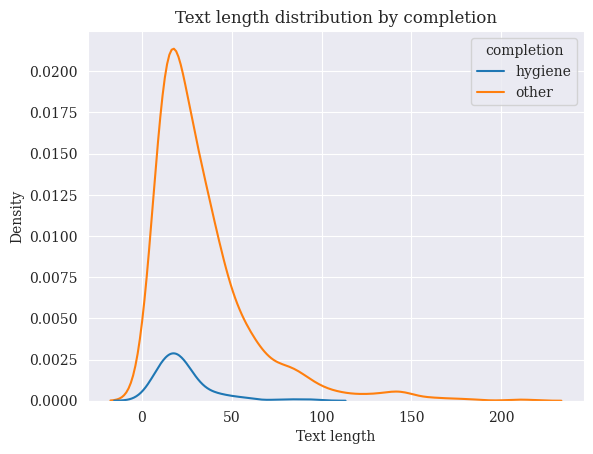

In [38]:
TEXT_LENGTH = "Text Length"
df[TEXT_LENGTH] = df[TEXT].apply(lambda x: word_tokenize(x)).apply(lambda x: len(x)).values
sns.kdeplot(data=df, x=TEXT_LENGTH, hue=TARGET)
plt.xlabel("Text length")
plt.title(f"Text length distribution by {TARGET}")
plt.show();

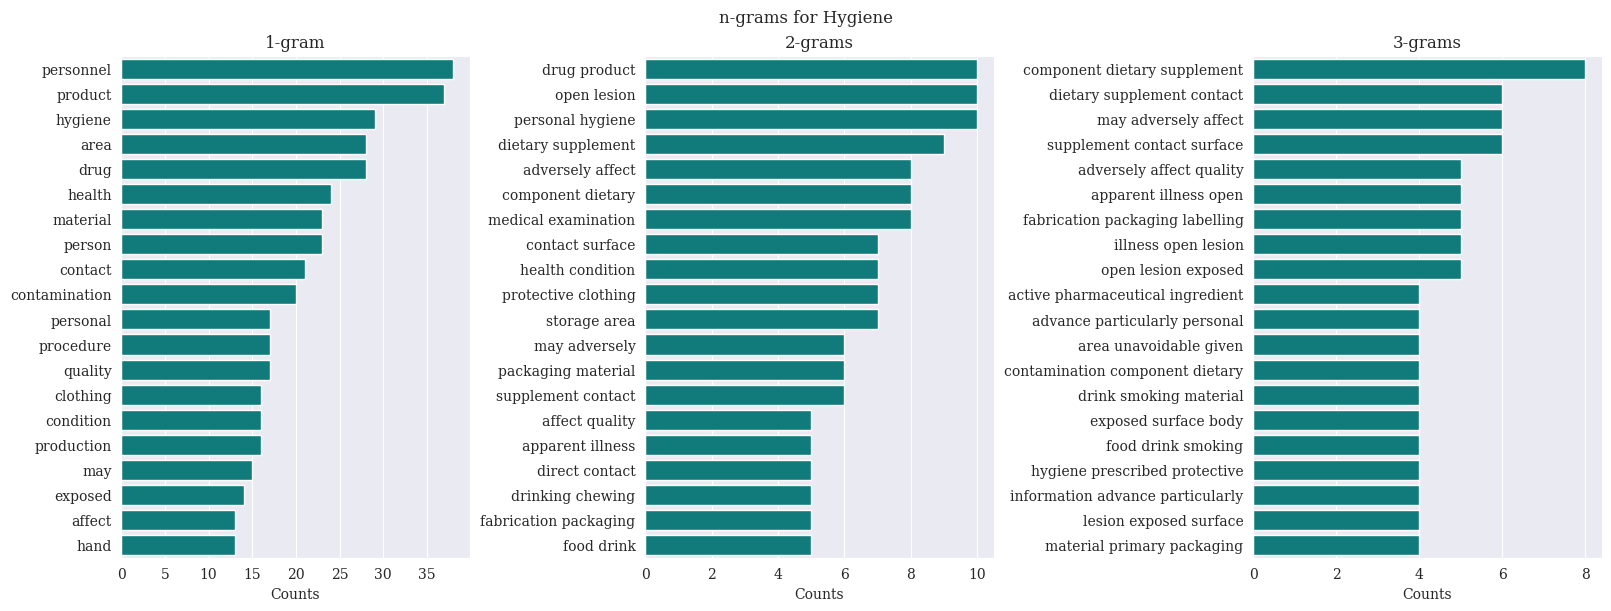

In [39]:
corpus = df[df[TARGET].isin(["hygiene"])][TEXT]
fig, ax = plt.subplots(1, 3, figsize=(16, 6), constrained_layout=True)
ngrams, counts = topK_ngrams(corpus, 1, 20)
sns.barplot(x=counts, y=ngrams, color=COLOR, ax=ax[0])
ngrams, counts = topK_ngrams(corpus, 2, 20)
sns.barplot(x=counts, y=ngrams, color=COLOR, ax=ax[1])
ngrams, counts = topK_ngrams(corpus, 3, 20)
sns.barplot(x=counts, y=ngrams, color=COLOR, ax=ax[2])
ax[0].set_xlabel("Counts")
ax[1].set_xlabel("Counts")
ax[2].set_xlabel("Counts")
ax[0].set_title("1-gram")
ax[1].set_title("2-grams")
ax[2].set_title("3-grams")
fig.suptitle("n-grams for Hygiene")
plt.show();

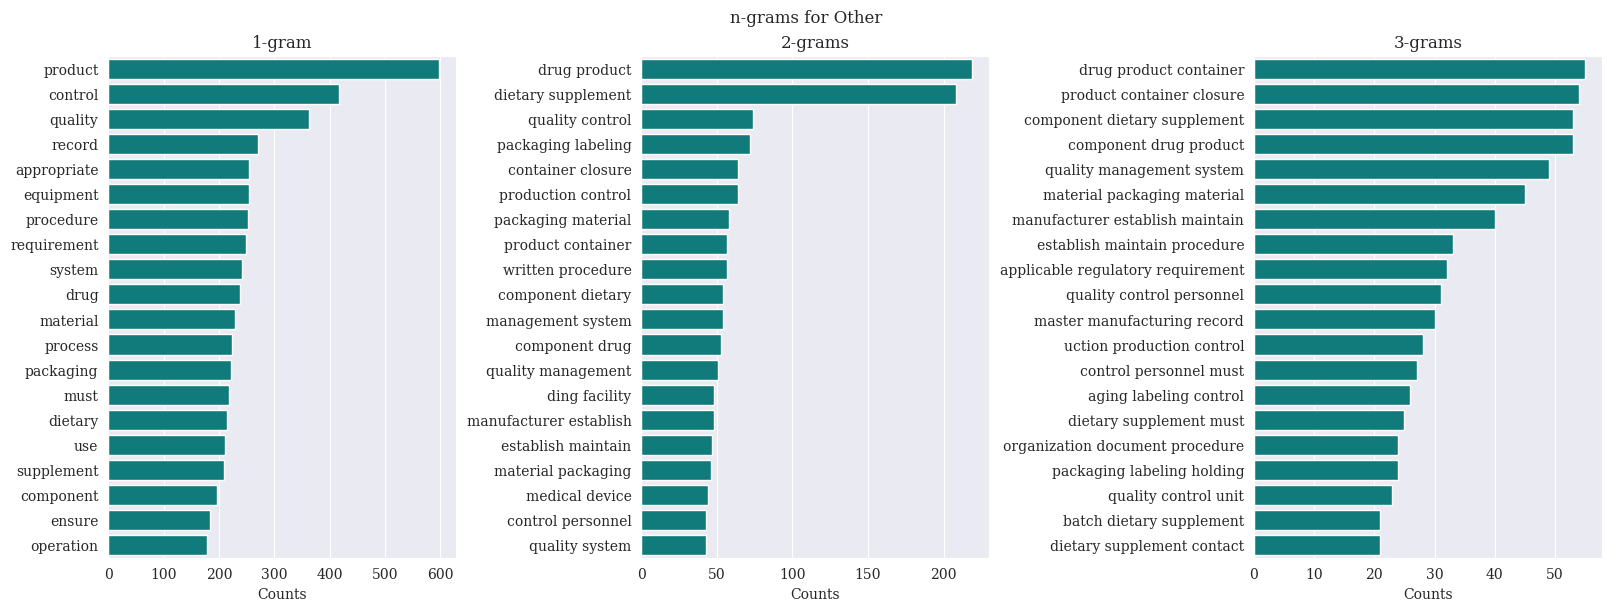

In [40]:
corpus = df[df[TARGET].isin(["other"])][TEXT]
fig, ax = plt.subplots(1, 3, figsize=(16, 6), constrained_layout=True)
ngrams, counts = topK_ngrams(corpus, 1, 20)
sns.barplot(x=counts, y=ngrams, color=COLOR, ax=ax[0])
ngrams, counts = topK_ngrams(corpus, 2, 20)
sns.barplot(x=counts, y=ngrams, color=COLOR, ax=ax[1])
ngrams, counts = topK_ngrams(corpus, 3, 20)
sns.barplot(x=counts, y=ngrams, color=COLOR, ax=ax[2])
ax[0].set_xlabel("Counts")
ax[1].set_xlabel("Counts")
ax[2].set_xlabel("Counts")
ax[0].set_title("1-gram")
ax[1].set_title("2-grams")
ax[2].set_title("3-grams")
fig.suptitle("n-grams for Other")
plt.show();